In [1]:
import numpy as np
import pickle
from scipy.stats import norm
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
import torch
from Chempy.parameter import ModelParameters

# Load & prepare the data

In [2]:
# ------ Load & prepare the data ------

# --- Load in training data ---
path_training = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = '../ChempyMulti/tutorial_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
def clean_data(x, y):
    # Remove all zeros from the data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)


train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
val_x = torch.tensor(val_x).float()
val_y = torch.tensor(val_y).float()

In [3]:
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

# Test the posterior

In [4]:
with open("data/posterior_sbi_w5p-error_noH.pickle", "rb") as f:
    posterior = pickle.load(f)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Index: 14909
x: tensor([-2.3247, -4.1934,  0.5243,  0.6033,  0.4271, 12.1278])
fit: tensor([-2.2249, -3.5983, -0.3058,  0.5526,  0.4984,  8.9757])


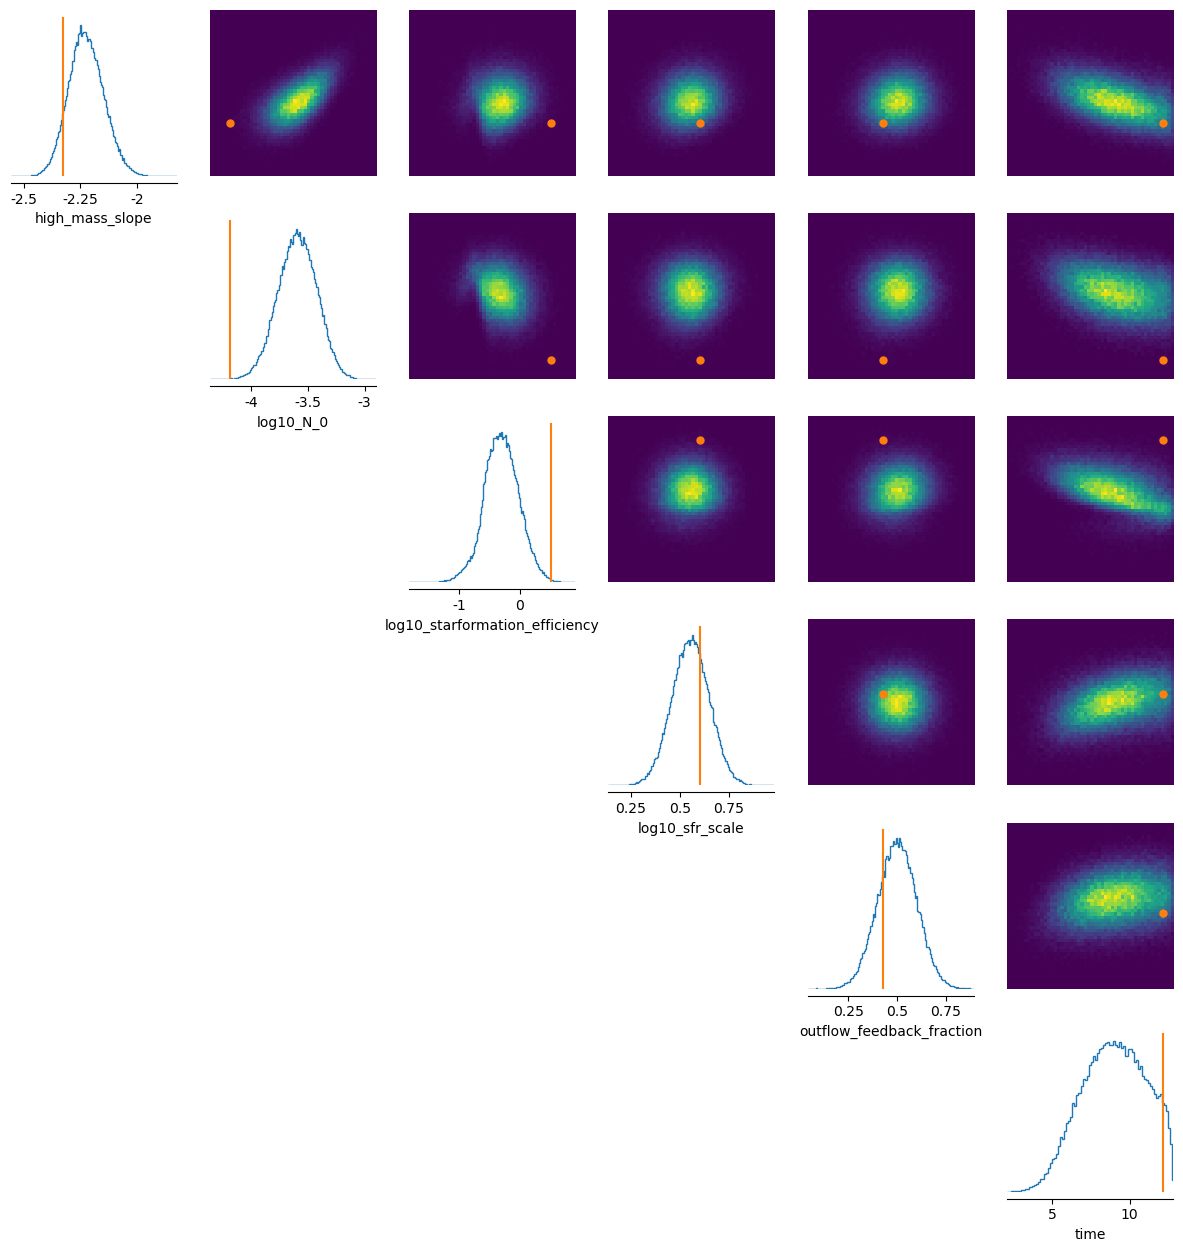

In [5]:
# pick a random point from the validation data
index = np.random.randint(0, len(val_x))
x = val_x[index]
y = val_y[index]
y = torch.cat([y[0:2], y[3:]])

# sample 10000 points from the posterior
posterior_samples = posterior.sample((100000,), x=y)

print(f'Index: {index}')
print(f'x: {x}')
print(f'fit: {posterior_samples.mean(axis=0)}')
# plot the posterior samples
_ = pairplot(posterior_samples, figsize=(15, 15), points=x, labels=labels)


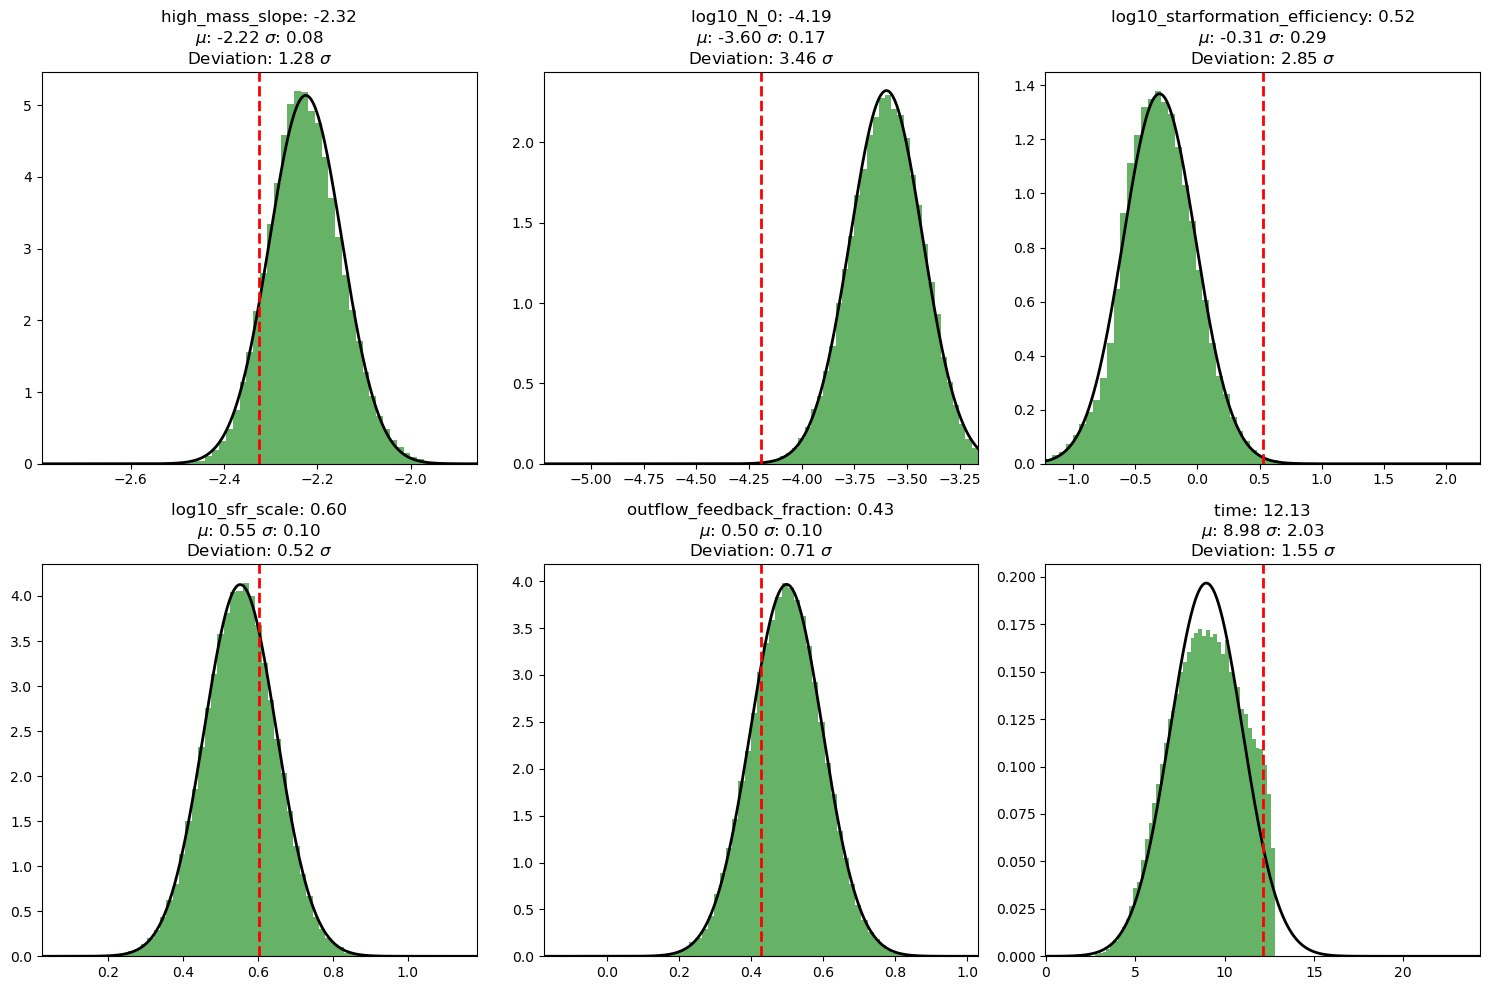

In [6]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))

for i in range(6):
    
    (mu, sigma) = norm.fit(posterior_samples.numpy().T[i])
    true_value = val_x[index][i].numpy()

    x_min = true_value - 6*sigma
    x_max = true_value + 6*sigma

    deviation = abs(true_value - mu) / sigma
    
    ax[i//3, i%3].hist(posterior_samples.numpy().T[i], bins=50, density=True, alpha=0.6, color='g')
    #xmin, xmax = ax[i//3, i%3].get_xlim()
    x = np.linspace(x_min, x_max, 1000)
    p = norm.pdf(x, mu, sigma)
    ax[i//3, i%3].set_xlim(x_min, x_max)
    ax[i//3, i%3].plot(x, p, 'k', linewidth=2)
    ax[i//3, i%3].axvline(x=true_value, color='r', linestyle='dashed', linewidth=2)
    
    ax[i//3, i%3].set_title(fr"{labels[i]}: {true_value:.2f}"
                            "\n"
                            fr"$\mu$: {mu:.2f} $\sigma$: {sigma:.2f}"
                            "\n"
                            fr"Deviation: {deviation:.2f} $\sigma$")
    
plt.tight_layout()
plt.show()